In [1]:
from statsbomb_data_extraction import Game, fetch_matches_for_season, fetch_all_seasons_for_league
from statsbomb_event_parsing import get_events_for_game, plot_event
from draw_pitch import draw_pitch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges

In [2]:
season_11_12 = fetch_matches_for_season("https://github.com/statsbomb/open-data/blob/master/data/matches/11/22.json")

In [3]:
events_df = get_events_for_game(season_11_12["69236"].json_file)
events_df

,eventname,x,y,xend,yend,statsbombxg,related events
ids,,,,,,,
f78d965c-131a-45c1-b2ac-4a059a349a83,pass,61.0,41.0,61.4,43.0,-1.0,[bb571e25-05a1-473c-82ca-e7d3f5bba3db]
0e1a1ed3-6295-40d4-b367-cc94b5163be5,pass,61.8,43.9,49.9,51.2,-1.0,[cdcc83d5-12a9-4f9d-8a35-5b00bf811491]
bed73e6e-222a-4c8a-acf4-acbc896d1669,carry,49.9,51.2,50.1,57.5,-1.0,"[1b8c0035-9d32-4483-b34e-5824b414e601, 5773bd7..."
5773bd78-085b-4728-a971-0b0ce79ab0b3,pass,50.1,57.5,62.7,75.2,-1.0,"[1b8c0035-9d32-4483-b34e-5824b414e601, 491964f..."
b486b934-ff52-431c-88f5-9d73ace3361f,carry,62.7,75.2,68.6,64.0,-1.0,"[301aa252-e9d6-45a8-a753-286785e16997, 3c54239..."
...,...,...,...,...,...,...,...
2adc0c95-dc5d-4b14-9210-5b33dee1edb0,carry,93.5,76.9,108.6,75.2,-1.0,"[5df97076-c757-477b-ba62-fa12f66fc640, 6ef3232..."
a902153e-8a9f-464a-a7b1-818e6ca39df8,pass,108.6,75.2,108.2,73.0,-1.0,[5858d320-baa5-4bed-915e-5bdac82b7c35]
30a4eff0-a1cc-44f3-9549-a90177090c92,pass,98.6,80.0,106.0,68.6,-1.0,[e9da71f9-d47d-47bb-b14b-c07f140f9576]


In [4]:
events_graph = nx.Graph()
events_graph.add_nodes_from(events_df.index)

for rows, cols in events_df.iterrows():
    events_graph.add_edges_from([(rows, x) for x in cols["related events"]])

In [50]:
def get_sequences(event_graph, event_df):
    all_sequences = []
    counted_events = set()
    for event in event_df.index:
        if event not in counted_events:
            sequence = np.array(list(dfs_edges(events_graph, event))).flatten()
            counted_events = counted_events | set(sequence)
            all_sequences.append(sequence)
    
    return all_sequences

def clean_sequences(sequence_list):
    cleaned_sequence_list = []
    for sequence in sequence_list:
        cleaned_sequence = []
        for i in range(1, sequence.shape[0]):
            if sequence[i] == sequence[i-1]:
                cleaned_sequence.append(sequence[i])
        cleaned_sequence_list.append(cleaned_sequence)
    return cleaned_sequence_list

all_sequences = get_sequences(events_graph, events_df)
all_sequences_cleaned = clean_sequences(all_sequences);

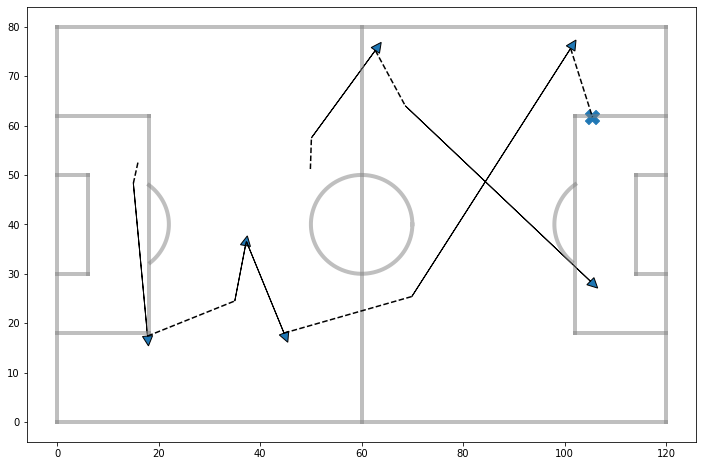

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(120/10, 80/10))
draw_pitch(axis=ax, rotate=True)
for sequence in all_sequences_cleaned[0:3]:
    for event in sequence:
        plot_event(events_df=events_df, eventid=event, axis=ax)